In [198]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns
from matplotlib import ticker
from shapely.geometry import Polygon, box
from sqlalchemy import create_engine

dosTPath = "../../../../../dosT/ffunes/"
unTPath = "../../../../../unT/ffunes/"
figuresPath = unTPath + "figures/"

%matplotlib inline
sns.set_theme()

Bar util

In [199]:
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [200]:
users = pd.read_pickle('../../../../../unT/ffunes/exact/users_exact_coords.pkl')

In [201]:
users.columns

Index(['unified_place', 'id', 'is_private', 'favourites_count',
       'followers_count', 'friends_count', 'listed_count', 'statuses_count',
       'location', 'support', 'screen_name', 'name', 'loc_in_argentina',
       'important', 'place_name', 'place_country', 'latitude', 'longitude'],
      dtype='object')

In [202]:
def to_lower(row, column):
    if not type(row[column] == str):
        return row[column]
    
    return str(row[column]).lower()

In [203]:
users["location"] = users.apply(to_lower, axis=1, column="location")

In [204]:
users.shape

(37146, 18)

In [205]:
users_with_profile = users.dropna(subset=["location"])
users_with_profile = users_with_profile[users_with_profile["location"] != "none"]
users_with_profile.shape

(29700, 18)

In [206]:
colnames = [
    "city_name",
    "latitude",
    "longitude",
    "country",
    "population"
]

geonames = pd.read_csv("../../../../../unT/ffunes/geonames/geonames_parsed.csv", usecols=colnames)

In [207]:
geonames.head()

,city_name,latitude,longitude,population,country
0,ehl tarter,42.579521,1.65362,1052,andorra
1,эл тартер,42.579521,1.65362,1052,andorra
2,san julia,42.463718,1.49129,8022,andorra
3,san julià,42.463718,1.49129,8022,andorra
4,sant julia de loria,42.463718,1.49129,8022,andorra


In [208]:
position = 0
total = users_with_profile.shape[0]
cities = geonames["city_name"].to_numpy()
countries = geonames["country"].unique()

def check_all_places(places, country):
    total_not_detected = 0
    total_exact = 0
    
    for place in places:
        ocurrences = np.where(cities == place)[0]
        
        if len(ocurrences) == 0:
            total_not_detected += 1
            continue
        
        for index in ocurrences:
            country_name = geonames["country"][index]
            
            if country_name == country:
                total_exact += 1
                break
    
    if total_exact == 1:
        return 'Ubicacion exacta'
    elif (total_not_detected == len(places)) | (total_exact == 0):
        return 'Ubicacion es un pais'
    return 'Ubicacion ambigua'

def es_univoco(value):
    global position;
    global total;
    global cities;
    
    location = value.replace("-", ",")
    location = location.replace("/", ",")
    all_words = location.split(',')
    all_words = [word.strip() for word in all_words]
    
    update_progress(position / total)
    position += 1
    
    if len(all_words) == 1:
        place = all_words[0]
        if place in countries:
            return 'Ubicacion es un pais'  
        
        ocurrences = np.where(cities == place)[0]
        
        if len(ocurrences) == 0:
            return 'No existe ubicacion'
        elif len(ocurrences) == 1:
            return 'Ubicacion exacta'
    
        return 'Ubicacion ambigua'
    
    #Veamos si alguna palabra es un País    
    for word in all_words:    
        if word in countries:
            all_words.remove(word)
            return check_all_places(all_words, word)
    
    counter = 0
        
    for word in all_words:    
        ocurrences = np.where(cities == word)[0]

        if len(ocurrences) == 0:
            counter += 1
        
    if counter == len(all_words):
        return 'No existe ubicacion'
        
    return 'Ubicacion ambigua'

In [209]:
users_with_profile["detected_location"] = users_with_profile['location'].apply(es_univoco)

Progress: [####################] 100.0%


In [210]:
users_with_profile["detected_location"].value_counts()

Ubicacion exacta        12370
No existe ubicacion      6358
Ubicacion ambigua        6315
Ubicacion es un pais     4657
Name: detected_location, dtype: int64

In [211]:
position = 0
total = users_with_profile.shape[0]
cities = geonames["city_name"].to_numpy()
countries = geonames["country"].unique()

def check_all_places_determine(places, country):
    total_not_detected = 0
    total_exact = 0
    index_exact = 0
    places_determined = []
    
    for place in places:
        ocurrences = np.where(cities == place)[0]
        
        if len(ocurrences) == 0:
            total_not_detected += 1
            continue
        
        for index in ocurrences:
            country_name = geonames["country"][index]
            
            if country == country_name:
                total_exact += 1
                places_determined.append({
                    "place": place,
                    "population":  geonames["population"][index],
                    "latitude":  geonames["latitude"][index],
                    "longitude":  geonames["longitude"][index]                        
                })
                break               
    
    if total_exact == 1:
        return [places_determined, country]
    elif (total_not_detected == len(places)) | (total_exact == 0):
        return [None, country]
    
    return [places_determined, country]

def determine_place(value):
    global position;
    global total;
    global cities;
    
    location = value.replace("-", ",")
    location = location.replace("/", ",")
    all_words = location.split(',')
    all_words = [word.strip() for word in all_words]
        
    update_progress(position / total)
    position += 1
    
    if len(all_words) == 1:
        place = all_words[0]        
        if place in countries:
            return [None, place]
        
        ocurrences = np.where(cities == place)[0]
                
        if len(ocurrences) == 0:
            return [None, None]
        elif len(ocurrences) == 1:
            return [[{
                "place": place,
                "population":  geonames["population"][ocurrences[0]],
                "latitude":  geonames["latitude"][ocurrences[0]],
                "longitude":  geonames["longitude"][ocurrences[0]]
            }], None]
        
        places_determined = []
        
        for index in ocurrences:
            places_determined.append({
                "place": place,
                "population":  geonames["population"][index],
                "latitude":  geonames["latitude"][index],
                "longitude":  geonames["longitude"][index]                        
            })
    
        return [places_determined, None]#'Ubicacion ambigua'
    
    #Veamos si alguna palabra es un País    
    for word in all_words:    
        if word in countries:
            all_words.remove(word)
            return check_all_places_determine(all_words, word)

    counter = 0
    places_determined = []
        
    for word in all_words:    
        ocurrences = np.where(cities == word)[0]

        if len(ocurrences) == 0:
            counter += 1
        else:
            for index in ocurrences:
                places_determined.append({
                    "place": word,
                    "population":  geonames["population"][index],
                    "latitude":  geonames["latitude"][index],
                    "longitude":  geonames["longitude"][index]                        
                })
        
    if counter == len(all_words):
        return [None, None]#'No existe ubicacion'
        
    return [places_determined, None]#'Ubicacion ambigua'

In [212]:
users_with_profile["profile_city"], users_with_profile["profile_country"] = zip(*users_with_profile['location'].apply(determine_place))

Progress: [####################] 100.0%


/var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [213]:
users = pd.merge(
    left=users,
    right=users_with_profile.loc[:, ["id", "detected_location", "profile_city", "profile_country"]],
    how='left',
    left_on='id',
    right_on='id',
    validate='1:1'
)

users.shape

(37146, 21)

In [214]:
users.to_pickle('../../../../../unT/ffunes/exact/users_exact_coords.pkl')

Analisis

In [215]:
users = pd.read_pickle('../../../../../unT/ffunes/exact/users_exact_coords.pkl')

In [216]:
users = pd.merge(
    left=users,
    right=geonames.rename(columns={"latitude": "lat_geo", "longitude": "lon_geo"}),
    how='inner',
    left_on=['place_name', 'place_country'],
    right_on=['city_name', 'country']
)

users.shape

(32592, 26)

In [217]:
users_with_profile = users.dropna(subset=["location"])
users_with_profile = users_with_profile[users_with_profile["location"] != "none"]
users_with_profile.shape

(26055, 26)

In [218]:
dist_profs = users_with_profile.groupby("detected_location").count().sort_values("id", ascending=False).reset_index()

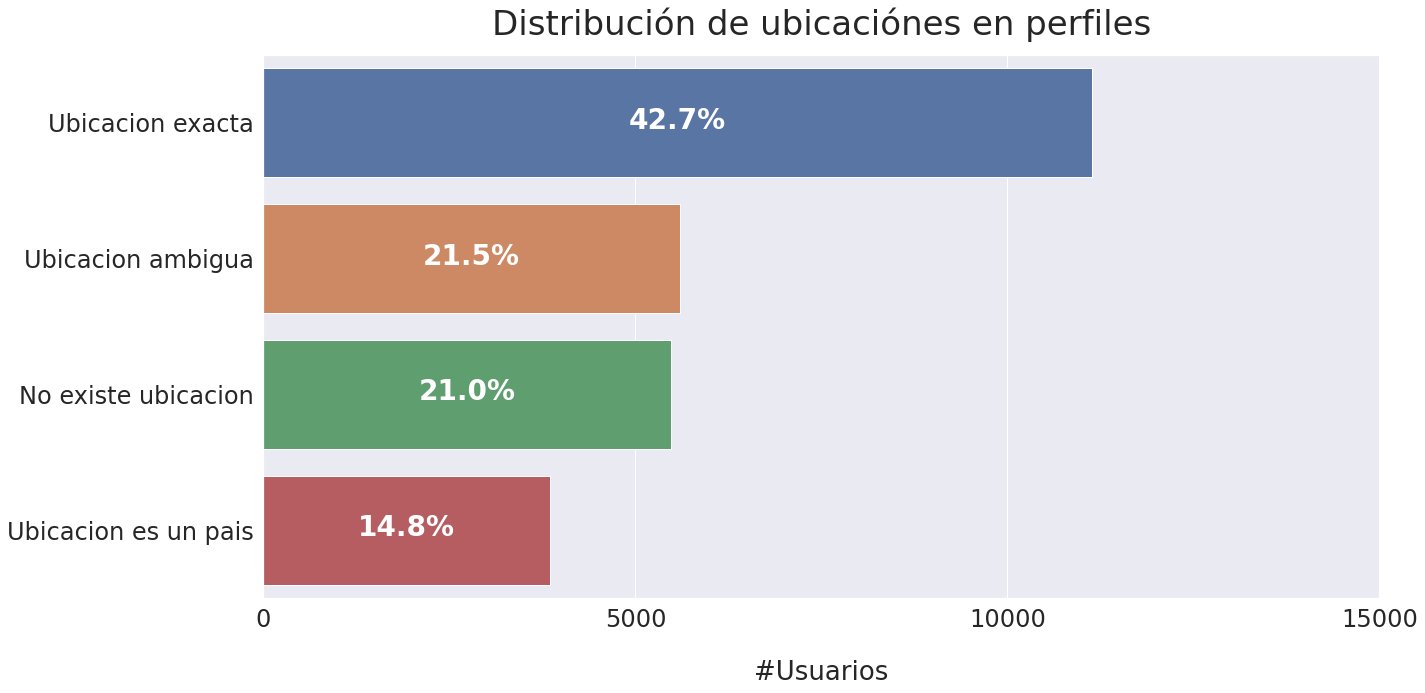

In [219]:
fig, ax = plt.subplots(figsize=(20, 10))
rects = sns.barplot(x="id", y="detected_location", data=dist_profs, ax=ax)
ax.set_title("Distribución de ubicaciónes en perfiles", fontsize=34, pad=20)
ax.set_xlabel("#Usuarios",fontsize=26, labelpad=28)
ax.set_ylabel("",fontsize=26)
ax.tick_params(axis='y', which='both', labelsize=24)
ax.tick_params(axis='x', which='both', labelsize=24)

plt.xticks(np.arange(0, np.max(dist_profs["id"]) + 5000, 5000.0))

for p in rects.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(
        '{0:.1%}'.format(width/users_with_profile.shape[0]),
        (x + width / 2.0, y + height / 1.8),
        ha='center',
        fontsize=28,
        color="white",
        weight='bold'
    )
    
plt.savefig(figuresPath + 'profile/profiles_loc_dist.pdf', bbox_inches = 'tight')
plt.show()

De los usuarios que se pudo obtener el pais, coincide un 91.7% con la mayoria de sus tweets!

In [220]:
total = users_with_profile.dropna(subset=["profile_country"]).shape[0]

a = users_with_profile.dropna(subset=["profile_country"])
subtotal = a.loc[a["profile_country"] == a["place_country"], :].shape[0]

subtotal / total

0.9079945114465228

De los usuarios con ubicacion exacta, coincide un 93% con la mayoria de sus tweets!

In [221]:
u = users_with_profile.loc[users["detected_location"] == "Ubicacion exacta", :]
total = u.dropna(subset=["profile_country"]).shape[0]

a = u.dropna(subset=["profile_country"])
subtotal = a.loc[a["profile_country"] == a["place_country"], :].shape[0]

subtotal / total

0.9194322475237414

In [222]:
def veracity(row):
    if row['profile_city'][0]['place'] == row['place_name']:
        return True
    
    return False

u = users_with_profile.loc[users_with_profile["detected_location"] == "Ubicacion exacta", :]
total = u.shape[0]

u["veracity"] = u.apply(veracity, axis=1)
subtotal = u.loc[u["veracity"] == True, :].shape[0]
subtotal / total

<ipython-input-222-32d1a9db15ee>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u["veracity"] = u.apply(veracity, axis=1)


0.5051657533015902

Veamos distancias para ubicacion exacta

In [223]:
users_with_exact_location = users_with_profile.loc[users_with_profile["detected_location"] == "Ubicacion exacta", :]
users_with_exact_location.shape

(11131, 26)

In [224]:
from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

In [225]:
def determine_distance(row):
    profile_lat = row['profile_city'][0]['latitude']
    profile_lon = row['profile_city'][0]['longitude']
    tweet_lat = row['lat_geo']
    tweet_long = row['lon_geo']
    
    return haversine_distance(profile_lat, profile_lon, tweet_lat, tweet_long)

In [226]:
users_with_exact_location["distance_dif_in_km"] = users_with_exact_location.apply(determine_distance, axis=1)

<ipython-input-226-1b4175f9dafe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_with_exact_location["distance_dif_in_km"] = users_with_exact_location.apply(determine_distance, axis=1)


In [227]:
users_with_exact_location.shape

(11131, 27)

In [228]:
users_with_exact_location.loc[users_with_exact_location["distance_dif_in_km"] == 0, :].shape

(7723, 27)

In [229]:
users_with_exact_location.loc[users_with_exact_location["distance_dif_in_km"] > 0].shape

(3408, 27)

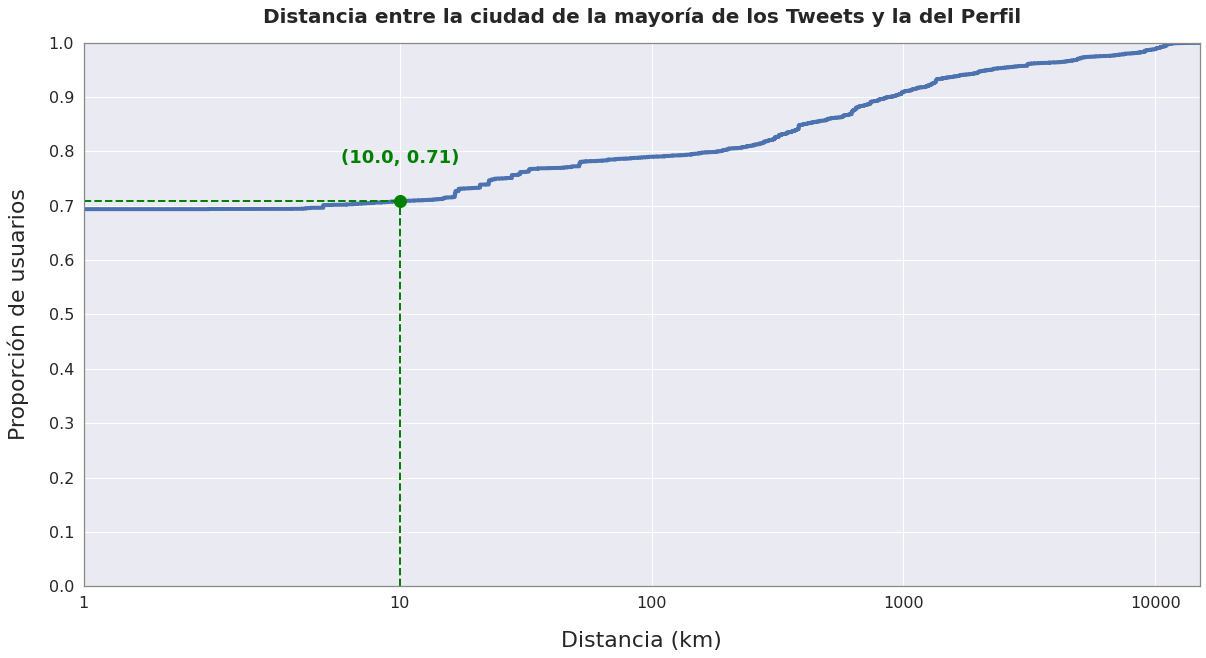

In [230]:
from math import log
f, ax = plt.subplots(figsize=(20, 10))

sns.ecdfplot(
    data=users_with_exact_location["distance_dif_in_km"],
    stat="proportion",
    #log_scale=True,
    #complementary=True,
    ax=ax,
    linewidth=4
)

mark_at = 10.0

perc = users_with_exact_location[users_with_exact_location["distance_dif_in_km"] < mark_at].shape[0] / users_with_exact_location.shape[0]

ax.set_ylim(0, 1.05)
ax.set_xlim(0, 15000)
ax.set_xscale('symlog')
ax.set_title("Distancia entre la ciudad de la mayoría de los Tweets y la del Perfil", fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel("Distancia (km)", fontsize=22, labelpad=20)
ax.set_ylabel("Proporción de usuarios", fontsize=22, labelpad=20)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))

ax.plot([0, mark_at], [perc, perc], color='green', linestyle='dashed', linewidth=2)
ax.plot([mark_at, mark_at], [0, perc], color='green', linestyle='dashed', linewidth=2)
ax.plot([mark_at], [perc], color='green', marker='o', markersize=12)

ax.annotate(
    '({}, {:.2f})'.format(mark_at, perc),
    (mark_at, perc + 0.07),
    ha='center',
    fontsize=18,
    color="green",
    weight='bold'
)

plt.gca().spines['bottom'].set_color('#888888')
plt.gca().spines['top'].set_color('#888888') 
plt.gca().spines['right'].set_color('#888888')
plt.gca().spines['left'].set_color('#888888')

plt.gca().set_xlim(left=1)
plt.gca().set_ylim(top=1)

plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
#plt.grid()
plt.show()

#ax.axvline(x=mark_at, ymax=perc-0.03, color='green')
#ax.axhline(y=perc-0.03, xmax=log(40.0)/log(10380), color='green')
f.savefig(figuresPath + 'profile/ecdf_distance_prof_maj_tweet2.pdf', bbox_inches = 'tight')

#f.savefig("../../results/plots/creacion_set_validacion/dif_distance_city_majority_tweets_and_profile.pdf", bbox_inches='tight')

VEamos casos de ubicación ambigua

In [231]:
def get_closest_place_to_tweet(row):
    minor_dist = -1

    for place in row["profile_city"]:
        profile_lat = place['latitude']
        profile_lon = place['longitude']
        tweet_lat = row['latitude']
        tweet_long = row['longitude']

        new_dist = haversine_distance(profile_lat, profile_lon, tweet_lat, tweet_long)

        if (new_dist < minor_dist) | (minor_dist == -1):
            minor_dist = new_dist
    
    return minor_dist

In [232]:
users_with_ambiguous_location = users_with_profile.loc[users_with_profile["detected_location"] == "Ubicacion ambigua", :]
users_with_ambiguous_location.shape

(5598, 26)

In [233]:
users_with_ambiguous_location["distance_dif_in_km"] = users_with_ambiguous_location.apply(determine_distance, axis=1)

<ipython-input-233-945c613f4369>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_with_ambiguous_location["distance_dif_in_km"] = users_with_ambiguous_location.apply(determine_distance, axis=1)


In [234]:
users_with_ambiguous_location[users_with_ambiguous_location["distance_dif_in_km"] < 10].shape[0] / users_with_ambiguous_location.shape[0]

0.4901750625223294